<h1>Convolutions and Convolutional Neural Networks</h1>
<img src="https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif" width="750" align="center">

The 2D Image convolution is a fairly simple operation that leads to powerful and somewhat surprising results! In this notebook we'll look at performing convolutions with a hand-crafted kernal and then look at how we can learn the parameters of a kernal to perform some task!

Have a look at this interactive convolution visualiser
[Convolution Visualizer](https://ezyang.github.io/convolution-visualizer/index.html)

In [1]:
import math
import random
import numpy as np
from PIL import Image
import copy

from IPython.display import clear_output
import matplotlib.pyplot as plt

#Pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


Let's load a test image to experiment with using the Python Imaging Library (PIL).<br>
Note: PIL images are themselves objects and the image can be displayed just by printing them

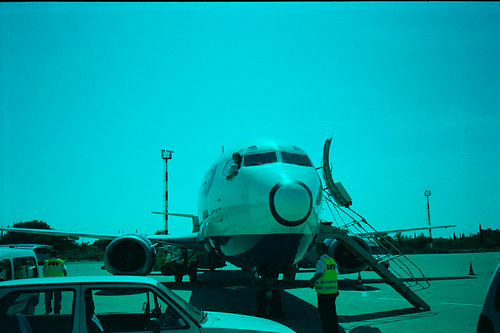

In [2]:
test_img1 = Image.open("Plane1.png").convert('RGB')
test_img1

In [3]:
#Lets create a Pytorch "transform" using the torchvision library 
#This particular transform simply takes a PIL image and converts it to a tensor
transform = T.ToTensor()
test_img1 = transform(test_img1)
print("Image Shape: ", test_img1.shape)
#NOTE:Many torchvision functions with only work on PIL images

Image Shape:  torch.Size([3, 333, 500])


<h2>Sobel Edge Detector</h2>
The Sobel Edge detector is a famous and simple convolutional kernal filter that will "extract" the edges of an image and was/is extensively used as a part of many algorithms. Here we will create a Sobel Filter and use it on our test image.<br> By looking at the filter can you tell how it works?

In [4]:
#First we must create a filter that will extract edges in the X direction
gx = torch.FloatTensor([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]]).unsqueeze(0)
#We'll repeat the kernel across the channel dimension so we have a 3 channel kernel
gx = torch.repeat_interleave(gx, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gx.shape)
print(gx)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])


In [6]:
#Now we must create a filter that will extract edges in the Y direction
gy = torch.FloatTensor([[1, 2, 1],[0, 0, 0],[-1, -2, -1]]).unsqueeze(0)
#We'll repeat the kernel across the channel dimension so we have a 3 channel kernel
gy = torch.repeat_interleave(gy, 3, 0).unsqueeze(0)
print("Kernel Shape: ", gy.shape)
print(gy)

Kernel Shape:  torch.Size([1, 3, 3, 3])
tensor([[[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]],

         [[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])


For the Pytorch function F.conv2d() (which will perform a convolution operation) the convolutional kernel must be of the shape  <br>
<b>[out channels, in channels, kernel height, kernel width]</b> <br>
The input image must have the shape <br>
<b>[minibatch size, in channels, image height, image width]</b> <br>

[torch.nn.functional.conv2d](https://pytorch.org/docs/master/nn.functional.html#torch.nn.functional.conv2d)

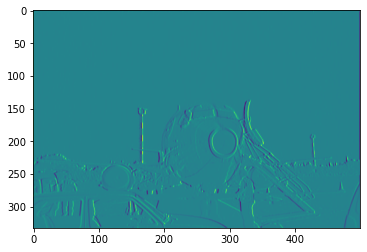

In [14]:
#convolve the image with the X direction kernel
conv_out1 = conv_out1 = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, padding=1, stride=1)
plt.imshow(torch.squeeze(conv_out1))

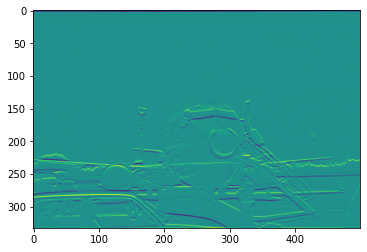

In [13]:
#convolve the image with the Y direction kernel
conv_out2 = conv_out1 = F.conv2d(test_img1.unsqueeze(0), gy, bias=None, padding=1, stride=1)
plt.imshow(torch.squeeze(conv_out2))

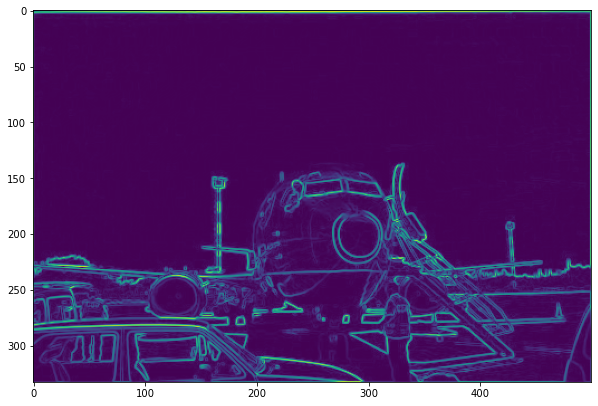

In [15]:
#Combine the two resulting images together by finding the magnitude
conv_out = (conv_out1.pow(2) + conv_out2.pow(2)).sqrt()
plt.figure(figsize = (10,10))
plt.imshow(torch.squeeze(conv_out))

<h2>Spot The Difference</h2>
Let's play a game of spot the difference and use convolutional filters to help!

[For Pytorch Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [16]:
#Let's load the second test image
test_img2 = Image.open("Plane2.png").convert('RGB')
test_img2 = transform(test_img2)

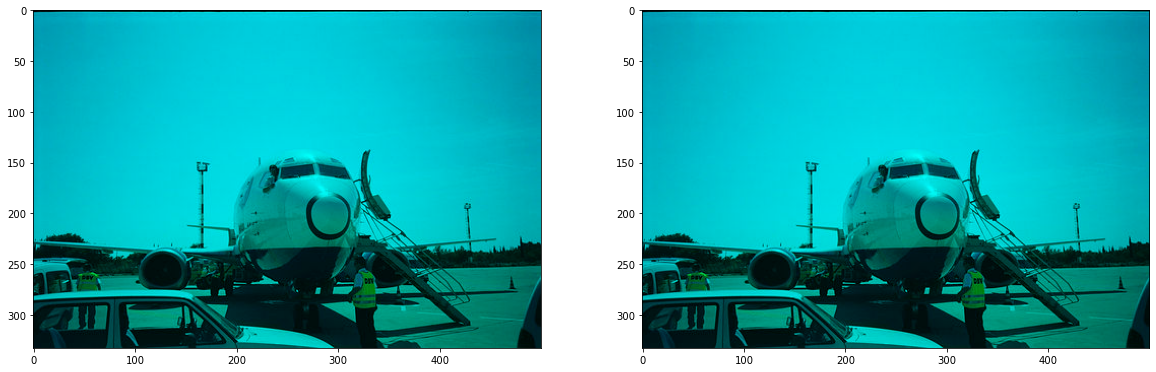

In [17]:
#Now let's plot them side-by-side
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,20))
ax1.imshow(test_img1.numpy().transpose((1,2,0)))
ax2.imshow(test_img2.numpy().transpose((1,2,0)))

<h2> Difference Image?</h2>
Hmmmmmmmm they look pretty similar... how about we just subtract one from another??

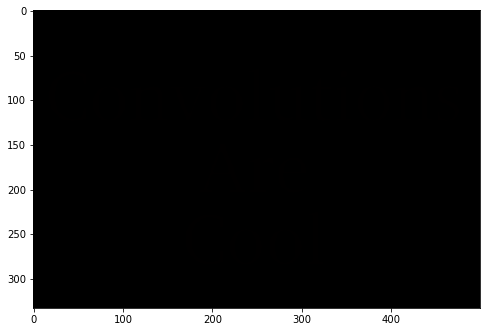

In [18]:
plt.figure(figsize = (8,8))
plt.imshow(test_img2.numpy().transpose((1,2,0)) - test_img1.numpy().transpose((1,2,0)))

Hmmmmm, looks like any difference between them is very small

<h2> Sobel Edges? </h2>
Maybe our friend the Sobel edge detector will help us?

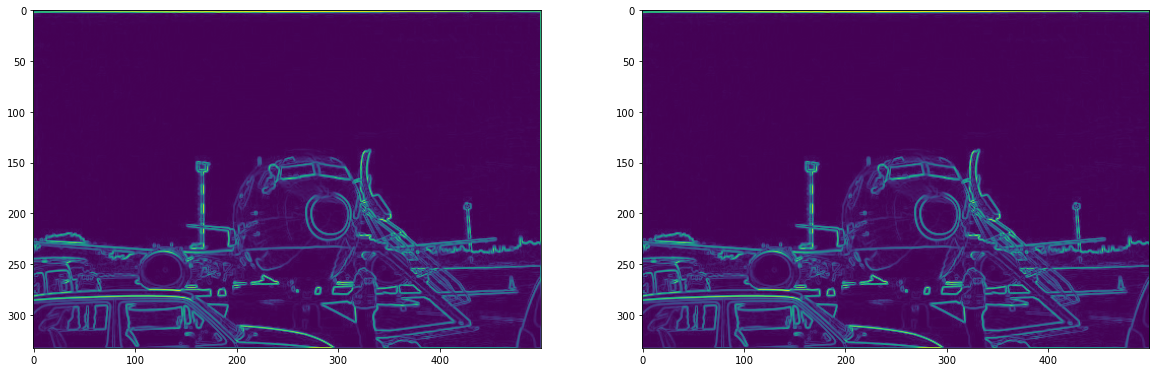

In [20]:
img_out1Y = F.conv2d(test_img1.unsqueeze(0), gy, bias=None, padding=1, stride=1)
img_out1X = F.conv2d(test_img1.unsqueeze(0), gx, bias=None, padding=1, stride=1)
img_out1  = (img_out1Y.pow(2) + img_out1X.pow(2)).sqrt()

img_out2Y = F.conv2d(test_img2.unsqueeze(0), gy, bias=None, padding=1, stride=1)
img_out2X = F.conv2d(test_img2.unsqueeze(0), gx, bias=None, padding=1, stride=1)
img_out2  = (img_out2Y.pow(2) + img_out2X.pow(2)).sqrt()

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax1.imshow(torch.squeeze(img_out1.detach()))
ax2.imshow(torch.squeeze(img_out2.detach()))

Nope! They still look the same!

<h2> Train a Convolution Kernel! </h2>
So how do you look for something when you don't know what you are looking for? Often in computer vision we know WHAT we want, but we aren't sure how to get it! For example if you want to create an algorithm to classify cats, you might start by creating a list of all the uniquely cat-like things about an image of a cat, but then how do you go about extracting them from an image?? What if there's something you forgot? <br>
So in comes machine learning, we specify an objective (a cost function or a loss) for some learning model with the hope that by minimizing that loss our model will do what we want! (as you may have learnt by now there's a LOT more to it then that)<br>
So what objective can we come up with to see the difference between these two images?

[For Pytorch Convolution Layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [22]:
#Lets create a learnable 2D convolutional layer
#in_channels   -3     - the number of input channels
#out_channels  -1     - the number of output channels - also the number of kernels in a layer
#kernel_size   -3     - the height and width of our kernel - can specify with a tuple for non-square kernels
#stride        -1     - the number of pixels the kernel will "step"
#bias          -False - same as a linear layer, 1 bias term per output channel
#padding       -1     - zero padding around the input image

conv_kernel = nn.Conv2d(
    in_channels=3,
    out_channels=1,
    kernel_size=3,
    stride=1,
    bias = False,
    padding = 1
)
#NOTE: have a look at the documentation for the default paraemter values

#Define an optimizer
learning_rate = 0.3
optimizer = optim.SGD(conv_kernel.parameters(), lr=learning_rate, momentum=0.03)

In [23]:
#Let's have a look at the kernel's shape
conv_kernel.weight.shape

torch.Size([1, 3, 3, 3])

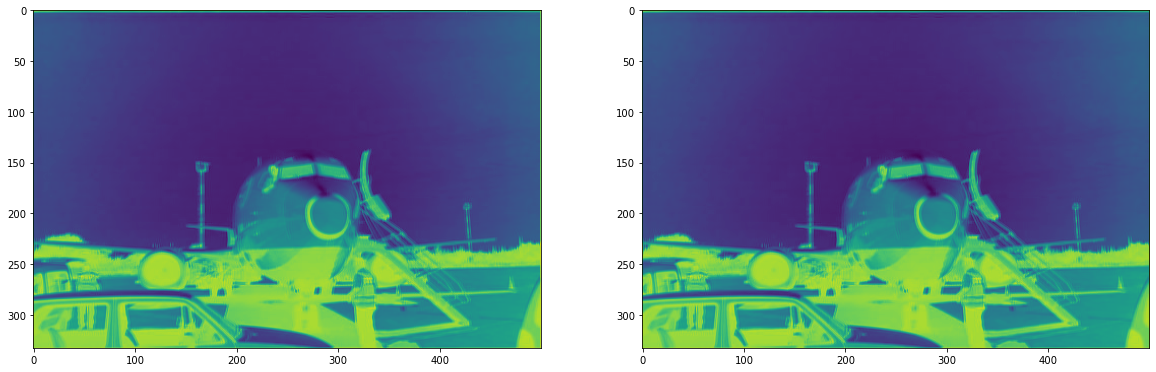

In [24]:
#We'll pass both images through the randomly initialised convolutional layers
img_out1 = conv_kernel(test_img1.unsqueeze(0))
img_out2 = conv_kernel(test_img2.unsqueeze(0))

f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax1.imshow(torch.squeeze(img_out1.detach()))
ax2.imshow(torch.squeeze(img_out2.detach()))

<b>Training our kernel!</b><br>
Have you come up with a loss function to use yet? Perform GD with it and see what you get!

In [35]:
logger =[]
for _ in range(100):
    img_out1 = conv_kernel(test_img1.unsqueeze(0))
    img_out2 = conv_kernel(test_img2.unsqueeze(0))
    loss = -(img_out2 - img_out1).pow(2).sum()
    
    logger.append(loss.item())
    conv_kernel.zero_grad()
    loss.backward()
    optimizer.step()
    clear_output(True)
    print(out.item())

9.39389011023195e-08


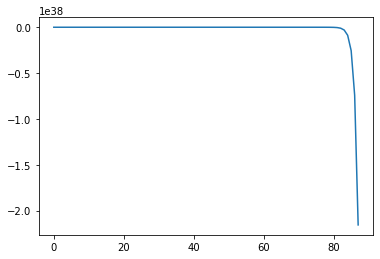

In [37]:
plt.plot(logger)

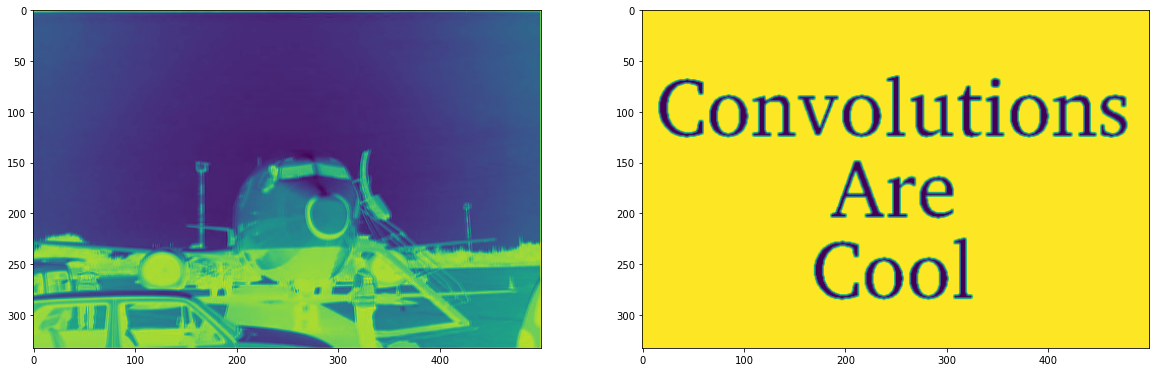

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize = (20,10))
ax1.imshow(torch.squeeze(img_out1.detach()))
ax2.imshow(torch.squeeze(img_out2.detach()))

In [39]:
print(conv_kernel.weight.data.round())

tensor([[[[-4.5626e+21, -4.7805e+21, -4.5581e+21],
          [-4.7194e+21, -4.9502e+21, -4.7194e+21],
          [-4.5582e+21, -4.7805e+21, -4.5626e+21]],

         [[ 0.0000e+00,  0.0000e+00, -0.0000e+00],
          [ 0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00]],

         [[-0.0000e+00, -0.0000e+00, -0.0000e+00],
          [-0.0000e+00,  0.0000e+00, -0.0000e+00],
          [-0.0000e+00, -0.0000e+00,  0.0000e+00]]]])
